<a href="https://colab.research.google.com/github/zhibinz2/Neural-Networks-and-Machine-Learning/blob/master/%E2%80%9CZHIBIN_Final_Project_Leave_One_Out_7_cnn_mnist%E2%80%9D20201209office_hour_copy.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [89]:
# set up
import tqdm

import torch
from torch import optim
from torch import nn


import torchvision
from torchvision import datasets, transforms
import torchvision.transforms as transforms
from torchvision import models, transforms
from torch.autograd import Variable

import pandas as pd
from PIL import Image
import requests
import io
import random, time, sys
from collections import namedtuple

import matplotlib.pyplot as plt

In [90]:
# load data from GitHub
import numpy as np
!wget https://github.com/zhibinz2/Neural-Networks-and-Machine-Learning/raw/master/AwakeSamples.npy
AwakeSamples=np.load('AwakeSamples.npy')
!wget https://github.com/zhibinz2/Neural-Networks-and-Machine-Learning/raw/master/SedatedSamples.npy
SedatedSamples=np.load('SedatedSamples.npy')

--2020-12-09 23:28:24--  https://github.com/zhibinz2/Neural-Networks-and-Machine-Learning/raw/master/AwakeSamples.npy
Resolving github.com (github.com)... 192.30.255.112
Connecting to github.com (github.com)|192.30.255.112|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/zhibinz2/Neural-Networks-and-Machine-Learning/master/AwakeSamples.npy [following]
--2020-12-09 23:28:24--  https://raw.githubusercontent.com/zhibinz2/Neural-Networks-and-Machine-Learning/master/AwakeSamples.npy
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 13249728 (13M) [application/octet-stream]
Saving to: ‘AwakeSamples.npy.6’

AwakeSamples.npy.6  100%[===================>]  12.64M  59.3MB/s    in 0.2s    

2020-12-09 23:28:24 (5

In [91]:
# Conbine two categories of samples into data
data=np.concatenate((AwakeSamples,SedatedSamples),axis=0)

In [92]:
# prepare the data to load into dataloader

import cv2
# resize matrices into 28 by 28 (for convolutional network only)
resize=np.zeros([400,28,28])
for j in np.array(range(400)):
    img=data[j,:,:]
    dim = (28, 28)
    resize[j,:,:] = cv2.resize(img, dim, interpolation = cv2.INTER_AREA)
    
data=resize

# Add one dimension
data=np.expand_dims(data, axis=1)

In [93]:
# load the targets from GitHub (for convolutional network only)
import numpy as np
!wget https://github.com/zhibinz2/Neural-Networks-and-Machine-Learning/raw/master/targets.npy
targets=np.load('targets.npy')

--2020-12-09 23:28:30--  https://github.com/zhibinz2/Neural-Networks-and-Machine-Learning/raw/master/targets.npy
Resolving github.com (github.com)... 192.30.255.113
Connecting to github.com (github.com)|192.30.255.113|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/zhibinz2/Neural-Networks-and-Machine-Learning/master/targets.npy [following]
--2020-12-09 23:28:30--  https://raw.githubusercontent.com/zhibinz2/Neural-Networks-and-Machine-Learning/master/targets.npy
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 3328 (3.2K) [application/octet-stream]
Saving to: ‘targets.npy.5’

targets.npy.5       100%[===================>]   3.25K  --.-KB/s    in 0s      

2020-12-09 23:28:30 (45.9 MB/s) - ‘targets.np

In [94]:
# import leave one out
from sklearn.model_selection import LeaveOneOut
loo = LeaveOneOut()

In [ ]:
loo.get_n_splits(data)

400

In [ ]:
loo.get_n_splits(targets)

400

In [95]:
# data loader
from torch.utils.data import Dataset
class MyTrainingDataset(Dataset):
    def __init__(self, root, transform=None, target_transform=None):
        self.root=root
        self.transform=transform
        self.target_transform=target_transform
        self.data=np.load(self.root[0])
        self.targets=np.load(self.root[1])
        
    def __len__(self):
        return len(self.data)
 
    def __getitem__(self, idx):
        sample=self.data[idx] 
        target=self.targets[idx]
        
        if self.transform:
            sample=self.transform(sample)
        if self.target_transform:
            target=self.target_transform(target)
            
        return sample, target

In [96]:
# 7_cnn_mnist.ipynb

class LeNet(torch.nn.Module):
    def __init__(self):
        super(LeNet, self).__init__()
        self.conv1 = torch.nn.Conv2d(1, 32, 3, 1)
        self.conv2 = torch.nn.Conv2d(32, 64, 3, 1)
        self.dropout1 = torch.nn.Dropout2d(0.25)
        self.dropout2 = torch.nn.Dropout2d(0.5)
        self.pool2 = torch.nn.MaxPool2d((2,2),(2,2))
        self.fc1 = torch.nn.Linear(9216, 128)
        self.fc2 = torch.nn.Linear(128, 2)
    def forward(self, x):
        x = self.conv1(x)
        x = torch.relu(x)
        x = self.conv2(x)
        x = self.pool2(x)
        x = torch.relu(x)
        x = self.dropout1(x)
        x = torch.flatten(x, 1)
        x = self.fc1(x)
        x = torch.relu(x)
        x = self.dropout2(x)
        x = self.fc2(x)
        return x

net = LeNet().cuda()

In [97]:
mse_loss = torch.nn.CrossEntropyLoss()
net = LeNet().cuda()
opt = torch.optim.Adam(net.parameters(), lr=1e-3)

In [98]:
def train_step(x, t, net, opt_fn, loss_fn):
    y = net(x.cuda())
    loss = loss_fn(y, t.cuda())
    loss.backward()
    opt_fn.step()
    opt_fn.zero_grad()
    return loss

In [110]:
# Leave one out loop and train the network
acc_hist_train = []
acc_hist_test = []

for train_index, test_index in loo.split(data):
  #print("TRAIN:", train_index, "TEST:", test_index)
  train_data, test_data = data[train_index], data[test_index]
  train_targets, test_targets = targets[train_index], targets[test_index]
  #print(train_data, test_data, train_targets, test_targets)

  net = LeNet().cuda()
  mse_loss = torch.nn.CrossEntropyLoss()
  opt = torch.optim.Adam(net.parameters(), lr=1e-3) 
  
  np.save('train_data.npy',train_data)
  np.save('train_targets.npy',train_targets)
  train_set=MyTrainingDataset(root=['train_data.npy', 'train_targets.npy'])

  np.save('test_data.npy',test_data)
  np.save('test_targets.npy',test_targets)
  test_set=MyTrainingDataset(root=['test_data.npy', 'test_targets.npy'])

  # set batch size and load into the dataloader
  batch=100
  train_loader = torch.utils.data.DataLoader(train_set, batch_size=batch, shuffle=True)
  test_loader = torch.utils.data.DataLoader(test_set, batch_size=batch, shuffle=False)

  # 7_cnn_mnist.ipynb
  x,t = next(iter(train_loader))

  train_step(x.float().cuda(), t.long().cuda(), net, opt, mse_loss)

  # Make prediction
  for x,t in iter(test_loader):   
    y = net(x.float().cuda()).cpu()

  # Calculate accuracy
  torch.mean((t == y.argmax(1)).float())
  # Train the network over multiple epochs
  for epoch in range(10):
      acc_batch = []
      for x,t in iter(train_loader):   
          loss_ = train_step(x.float(), t.long(), net, opt, mse_loss)
          y = net(x.float().cuda()).cpu()
          acc_batch.append(torch.mean((t == y.argmax(1)).float()))
      acc_hist_train.append(torch.mean(torch.FloatTensor(acc_batch)))   
      print(loss_)

      acc_batch = []
      for x,t in iter(test_loader):   
          y = net(x.float().cuda()).cpu()
          acc_batch.append(torch.mean((t == y.argmax(1)).float()))
      acc_hist_test.append(torch.mean(torch.FloatTensor(acc_batch)))  


tensor(0.6830, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(0.7062, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(0.7263, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(0.6794, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(0.6415, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(0.6302, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(0.6115, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(0.5764, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(0.5819, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(0.5085, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(0.7246, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(0.6948, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(0.6903, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(0.6936, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(0.6824, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(0.6757, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(0.6778, device='cuda:0', grad_fn=<NllLossBackward

In [111]:
acc_hist_train

[tensor(0.5188),
 tensor(0.5388),
 tensor(0.5336),
 tensor(0.5513),
 tensor(0.6367),
 tensor(0.6716),
 tensor(0.6768),
 tensor(0.6667),
 tensor(0.7568),
 tensor(0.7320),
 tensor(0.5011),
 tensor(0.5239),
 tensor(0.5539),
 tensor(0.5262),
 tensor(0.5514),
 tensor(0.5890),
 tensor(0.6391),
 tensor(0.6013),
 tensor(0.6390),
 tensor(0.6593),
 tensor(0.5262),
 tensor(0.4962),
 tensor(0.5640),
 tensor(0.5314),
 tensor(0.5337),
 tensor(0.5363),
 tensor(0.5437),
 tensor(0.6065),
 tensor(0.5738),
 tensor(0.6919),
 tensor(0.5111),
 tensor(0.5540),
 tensor(0.5287),
 tensor(0.5162),
 tensor(0.5739),
 tensor(0.5889),
 tensor(0.6542),
 tensor(0.6442),
 tensor(0.6591),
 tensor(0.6769),
 tensor(0.5337),
 tensor(0.5038),
 tensor(0.5865),
 tensor(0.5286),
 tensor(0.5941),
 tensor(0.6240),
 tensor(0.6014),
 tensor(0.6416),
 tensor(0.6593),
 tensor(0.7142),
 tensor(0.4863),
 tensor(0.5666),
 tensor(0.5813),
 tensor(0.6167),
 tensor(0.6290),
 tensor(0.5762),
 tensor(0.6116),
 tensor(0.6842),
 tensor(0.7041

In [112]:
acc_hist_test

[tensor(0.),
 tensor(1.),
 tensor(1.),
 tensor(1.),
 tensor(1.),
 tensor(1.),
 tensor(1.),
 tensor(1.),
 tensor(1.),
 tensor(1.),
 tensor(0.),
 tensor(0.),
 tensor(1.),
 tensor(1.),
 tensor(0.),
 tensor(1.),
 tensor(1.),
 tensor(1.),
 tensor(1.),
 tensor(1.),
 tensor(0.),
 tensor(1.),
 tensor(0.),
 tensor(1.),
 tensor(1.),
 tensor(0.),
 tensor(1.),
 tensor(1.),
 tensor(1.),
 tensor(1.),
 tensor(0.),
 tensor(0.),
 tensor(0.),
 tensor(0.),
 tensor(0.),
 tensor(0.),
 tensor(0.),
 tensor(1.),
 tensor(1.),
 tensor(1.),
 tensor(0.),
 tensor(1.),
 tensor(0.),
 tensor(1.),
 tensor(1.),
 tensor(1.),
 tensor(1.),
 tensor(1.),
 tensor(1.),
 tensor(1.),
 tensor(1.),
 tensor(1.),
 tensor(1.),
 tensor(1.),
 tensor(1.),
 tensor(1.),
 tensor(1.),
 tensor(1.),
 tensor(1.),
 tensor(1.),
 tensor(0.),
 tensor(0.),
 tensor(0.),
 tensor(1.),
 tensor(1.),
 tensor(1.),
 tensor(1.),
 tensor(1.),
 tensor(1.),
 tensor(1.),
 tensor(0.),
 tensor(1.),
 tensor(0.),
 tensor(1.),
 tensor(0.),
 tensor(1.),
 tensor(0.),

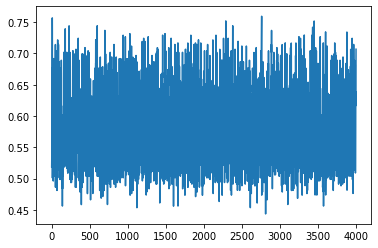

In [113]:
import pylab as plt
plt.plot(range(len(acc_hist_train)), acc_hist_train)

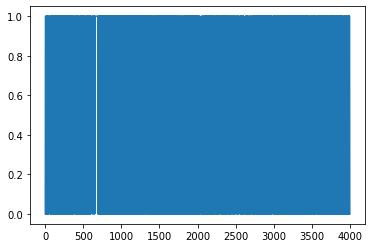

In [114]:
plt.plot(range(len(acc_hist_test)), acc_hist_test)

In [115]:
# test accuracy of the last 1000 steps of training
Test_accuracy=np.mean(acc_hist_test)
Test_accuracy

0.58225

In [ ]:
# We can plot the kernels learned by the CNN
net.conv1 #This is the first convolutional layer

Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1))

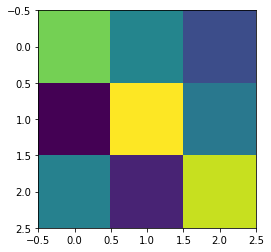

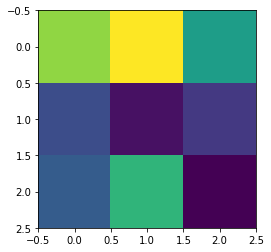

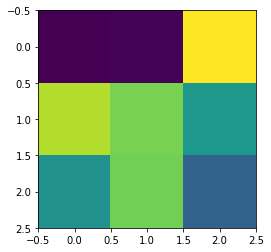

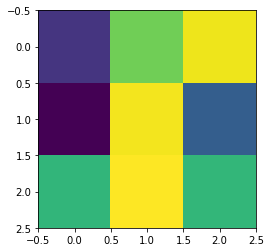

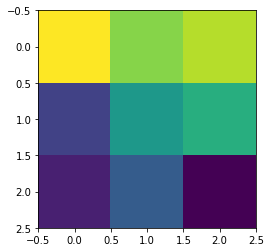

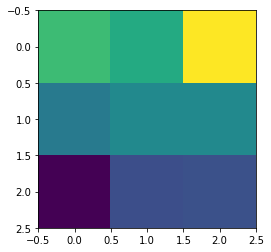

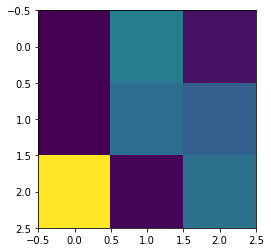

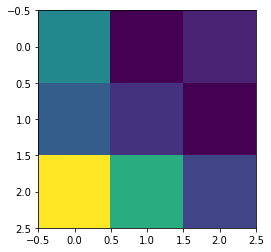

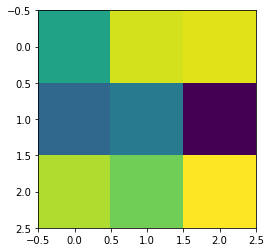

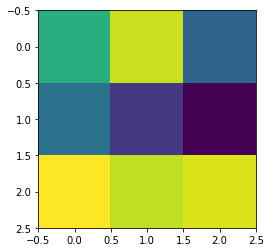

In [ ]:
import pylab
for i in range(10):
    pylab.figure();
    pylab.imshow(net.conv1.weight.data[i].cpu().detach().view(3,3))